CLUSTERING CON INCERTIDUMBRE

Primero, para poder ejecutar el código es necesario instalar los paquetes msotrados. Si no te deja, es necesario indicar en el comando de "pip install" el flag --User o -U

In [218]:
#Packages to install

#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install matplotlib
#!pip install scikit-learn
#!pip install ipywidgets

A continuación los imports necesarios. De momento ipywidgtes no es necesario por lo que se puede comentar si da algún tipo de problema

In [248]:
#Imports

import math
import pandas as pd
import numpy as np
import scipy as sp
import random as rd
import ipywidgets as widgets
import matplotlib.pyplot as plt
from sklearn import preprocessing

#Interactive plot
#%matplotlib notebook
#%matplotlib inline

La primera clase creada es DataSet.

Esta estructura de datos tiene como objetivo facilitar el cargar archivos haciendo uso de la librería pandas. 

En el constructor solo tienes que pasar la ruta de archivo deseada. De momento el código mostrado tiene rutas ed archivo locales y no relativas. Comprobar que las rutas están bien en caso de error.

Para leer el archivo deseado, llamar al método Read el cual incluye como parámetro el carácter de separación, el cual siempre debe ser ','.

La ventaja de esta estructura de datos es que podemos dibujar directamente los puntos del archivo csv.

In [249]:
class DataSet:
    
    data = []
    list_points = []
    
    def __init__(self, file_path):
        self.file_path = file_path
        
    #Derived
    def Read(self, sep):
        self.data = pd.read_csv(self.file_path, sep=sep,encoding='utf8')
        
    def DrawData(self, drawType):
        drawPoint = []
        allX = []
        allY =[]

        for index, row in self.getData().iterrows():
            p = Point(row['Coord X'],row['Coord Y'])
            self.list_points.append(p)
            allX.append(p.x)
            allY.append(p.y)

        drawPoint.append(allX)
        drawPoint.append(allY) 
        
        plt.plot(drawPoint[0],drawPoint[1],drawType)

La clase punto siemplemente se encarga de guardar dos valores, las componentes de una coordenada: posición x e y.

In [250]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

La clase círculo como su nombre bien indica es una estructura de datos encargada de gestionarlo.

Contiene la información del centro de la circunferencia, radio, numero de putnos que se compone y sus valores en coordenadas.

En el constructor simplemente se pasa el centro, radio y número de puntos deseados. 

El método Update simplemente modifica los valores de centro y radio.

El método Draw se limita a realizar un esbozo del círculo.

In [251]:
class Circle:
    
    center = 0
    readius = 0
    numOfPoints = 0
    xVals = []
    yVals = []
    
    def __init__(self, center, radius, numOfPoints):
        self.center = center
        self.radius = radius
        self.numOfPoints = numOfPoints
        self.__Calculate()
      
    #Derived
    def __Calculate(self):
        
        self.xVals = []
        self.yVals = []
        
        alpha = 2*math.pi/self.numOfPoints
        i = 0     
        while i < 2*math.pi:
            self.xVals.append(self.center.x + self.radius*math.cos(i))
            self.yVals.append(self.center.y + self.radius*math.sin(i))
            i += alpha
            
    def Update(self, center, radius):
        self.center = center
        self.radius = radius
        self.__Calculate()
    
    def Draw(self):
        if(len(self.xVals) == 0 or len(self.yVals) == 0):
            print('Error when drawing: Values are empty')
        else:
            xPrimeVals = self.xVals
            xPrimeVals.append(xPrimeVals[0])
            
            yPrimeVals = self.yVals
            yPrimeVals.append(yPrimeVals[0])
            
            plt.plot(xPrimeVals,yPrimeVals)
            plt.plot(self.center.x,self.center.y,'ro')

La Clase canvas es la que usaremos principalmente para visualziar los ddatos.

Recibe como parámetro una altura, anchura y datos.

Lo más importante de esta clase es el transformar los Datos a Puntos del que se encarga el método privado "__DataToPoints".

Luego tenemos más métodos:

DrawData(): Simplemente dibuja los puntos que se han pasado en el constructor

RemoveRandomPoints(percentage): Para eliminar puntos de los datos. Indica el porcentaje de los puntos que quieran ser borrados, de forma aleatoria.

InsertNoise(devX,devY): Para añadir ruido a los datos. Se pasa como parámetro la desviación que queremos tanto en la X como en la Y

Luego tenemos dos métodos para generar circunferencias alteatorias con el objetivo de generar Datos.

DrawRandomCircles_r(numOfCircles, precision): Genera circufnerencias aletatoris con un radio alteatorio. Genera tantas circufnerencias como se indique en el parámetro de la función

DrawRandomCircles(numOfCircles, minRadius, maxRadius, precision): Igual que "DrawRandomCircles_r" pero además indicando las longitudes del radio que deseemos.

In [252]:
class Canvas:
    
    width = 0
    height = 0
    data = []
    points = []
    
    def __init__(self, width, height, data):
        self.width = width
        self.height = height
        self.data = data
        self.points = self.__DataToPoints()
   
    #Derived
    def __DataToPoints(self):
        res = []        
        for i in range (0,len(self.data)):            
            for j in range(0,self.data[i].numOfPoints):                
                point=[]
                point.append(self.data[i].xVals[j])
                point.append(self.data[i].yVals[j])              
                point.append("Circulo"+str(i+1))
                
                res.append(point)
        return res
    
    def DrawData(self):
        for i in range (0,len(self.points)):
            plt.plot(self.points[i][0],self.points[i][1],'ro')
    
    def RemoveRandomPoints(self,percentage):
        
        if len(self.points) != 0:
            pointsToRemove = int(len(self.points)*percentage)
            newArrayLen = len(self.points)

            for i in range (0, pointsToRemove):
                j = rd.randint(0,newArrayLen-1)
                self.points.pop(j)
                newArrayLen -= 1
        else:
            print("Data debe tener al menos un punto.")
    
    def InsertNoise(self,devX,devY):
        noiseX = np.random.normal(0,devX,len(self.points))
        noiseY = np.random.normal(0,devY,len(self.points))
        
        for i in range(0,len(self.points)):
            self.points[i][0] += noiseX[i]
            self.points[i][1] += noiseY[i]
            
    def DrawRandomCircles_r(self,numOfCircles, precision):
            
        for i in range (0,numOfCircles):
            
            maxRad = 0
            
            if(self.width > self.height):
                maxRad = self.height/2
            else:
                 maxRad = self.width/2
            
            radius = rd.uniform(1,maxRad)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)
                       
            c = Circle(Point(centerX,centerY),radius,precision)
            self.data.append(c)
            c.Draw()
        
        self.points = self.__DataToPoints()
            
    def DrawRandomCircles(self,numOfCircles, minRadius, maxRadius, precision):
            
        for i in range (0,numOfCircles):
                       
            radius = rd.uniform(minRadius,maxRadius)
            centerX = rd.uniform(radius,self.width-radius)
            centerY = rd.uniform(radius,self.height-radius)                       
            c = Circle(Point(centerX,centerY),radius,precision)
            
            self.data.append(c)
            c.Draw()
            
        self.points = self.__DataToPoints()

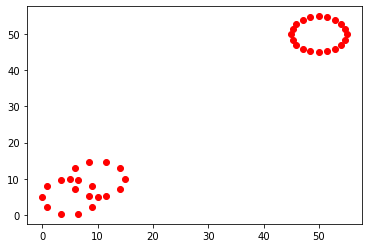

In [253]:
#Set Circles
c = Circle(Point(5,5),5,10)
c2 = Circle(Point(10,10),5,10)
c3 = Circle(Point(50,50),5,20)

can = Canvas(100,100,[c,c2,c3])
can.DrawData()

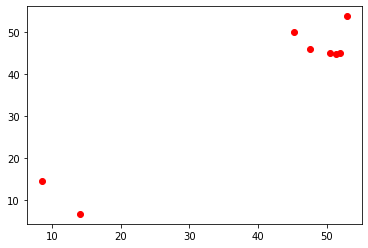

In [254]:
can.RemoveRandomPoints(0.3)
can.insertNoise(1,0.2)
can.DrawData()

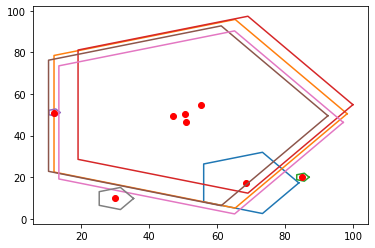

In [255]:
canvas = Canvas(100,100,[])
canvas.DrawRandomCircles_r(8,5)

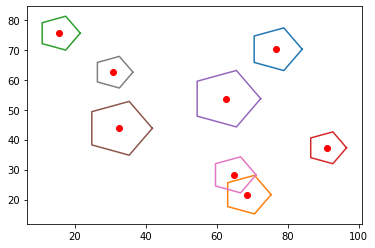

In [263]:
canvas2 = Canvas(100,100,[])
canvas2.DrawRandomCircles(8,5,10,5)
headers = ['Coord X','Coord Y', 'Circulo']
df = pd.DataFrame(canvas2.points, columns= headers)

In [264]:
file_path = r"C:\Users\enri8\Desktop\Universidad\IA\Proyecto\ClusteringIA\Datos\datos_xport.csv"
df.to_csv(file_path, columns=headers, index=False, encoding="utf8")

In [265]:
setDatos = DataSet(file_path)
setDatos.Read(',')

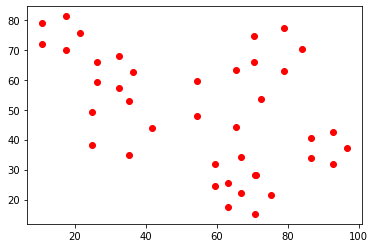

In [266]:
setDatos.DrawData('ro')